## K-means to segment customer based on RFM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
df = pd.read_csv('Onlineretail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom
2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom


In [3]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,203422.000000,203422.000000,150039.000000
mean,9.585684,4.877820,15240.234832
std,240.921315,113.686676,1717.658493
min,-74215.000000,0.000000,12346.000000
25%,1.000000,1.250000,13791.000000
50%,3.000000,2.100000,15061.000000
75%,10.000000,4.130000,16771.000000
max,74215.000000,38970.000000,18287.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203422 entries, 0 to 203421
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    203422 non-null  object 
 1   StockCode    203422 non-null  object 
 2   Description  202623 non-null  object 
 3   Quantity     203422 non-null  int64  
 4   InvoiceDate  203422 non-null  object 
 5   UnitPrice    203422 non-null  float64
 6   CustomerID   150039 non-null  float64
 7   Country      203422 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 12.4+ MB


In [5]:
df.isnull().sum()

InvoiceNo          0
StockCode          0
Description      799
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     53383
Country            0
dtype: int64

In [6]:
df_rfm = df.drop(columns=['Description',"Country", 'StockCode'])
df_rfm.columns

Index(['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID'], dtype='object')

In [7]:
df_rfm = df_rfm[df_rfm['Quantity']>0]
df_rfm = df_rfm[df_rfm['UnitPrice']>0]
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198451 entries, 0 to 203421
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    198451 non-null  object 
 1   Quantity     198451 non-null  int64  
 2   InvoiceDate  198451 non-null  object 
 3   UnitPrice    198451 non-null  float64
 4   CustomerID   146478 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 9.1+ MB


In [8]:
df_rfm.isnull().sum()

InvoiceNo          0
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     51973
dtype: int64

In [9]:
df_rfm.dropna(inplace=True)
df_rfm = df_rfm.drop_duplicates()
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92374 entries, 0 to 203398
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    92374 non-null  object 
 1   Quantity     92374 non-null  int64  
 2   InvoiceDate  92374 non-null  object 
 3   UnitPrice    92374 non-null  float64
 4   CustomerID   92374 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.2+ MB


In [10]:
df_rfm

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID
0,539993,10,2011-01-04 10:00:00,1.95,13313.0
1,539993,25,2011-01-04 10:00:00,0.42,13313.0
3,539993,5,2011-01-04 10:00:00,2.10,13313.0
4,539993,10,2011-01-04 10:00:00,1.25,13313.0
6,539993,6,2011-01-04 10:00:00,3.25,13313.0
...,...,...,...,...,...
203392,558637,1,2011-06-30 20:08:00,1.25,17891.0
203393,558637,1,2011-06-30 20:08:00,2.95,17891.0
203395,558637,1,2011-06-30 20:08:00,2.10,17891.0
203396,558637,12,2011-06-30 20:08:00,0.85,17891.0


In [11]:
df_rfm['Cost'] = df_rfm["Quantity"]*df_rfm['UnitPrice']
df_rfm.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Cost
0,539993,10,2011-01-04 10:00:00,1.95,13313.0,19.5
1,539993,25,2011-01-04 10:00:00,0.42,13313.0,10.5
3,539993,5,2011-01-04 10:00:00,2.10,13313.0,10.5
4,539993,10,2011-01-04 10:00:00,1.25,13313.0,12.5
6,539993,6,2011-01-04 10:00:00,3.25,13313.0,19.5


In [12]:
df_invoice = df_rfm[['InvoiceNo',"Cost"]].groupby('InvoiceNo').sum()
df_invoice.head()

,Cost
InvoiceNo,
539993,211.30
540001,454.50
540002,310.28
540003,198.05
540004,76.32


In [13]:
df_rfm['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Kiểm tra kiểu dữ liệu của cột InvoiceDate
print(df_rfm['InvoiceDate'].dtype)

datetime64[ns]


In [14]:
df_rfm.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Cost
0,539993,10,2011-01-04 10:00:00,1.95,13313.0,19.5
1,539993,25,2011-01-04 10:00:00,0.42,13313.0,10.5
3,539993,5,2011-01-04 10:00:00,2.10,13313.0,10.5
4,539993,10,2011-01-04 10:00:00,1.25,13313.0,12.5
6,539993,6,2011-01-04 10:00:00,3.25,13313.0,19.5


In [15]:
df_rfm.tail()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Cost
203392,558637,1,2011-06-30 20:08:00,1.25,17891.0,1.25
203393,558637,1,2011-06-30 20:08:00,2.95,17891.0,2.95
203395,558637,1,2011-06-30 20:08:00,2.10,17891.0,2.10
203396,558637,12,2011-06-30 20:08:00,0.85,17891.0,10.20
203398,558637,20,2011-06-30 20:08:00,0.65,17891.0,13.00


In [16]:
now = df_rfm['InvoiceDate'].max() 
now - df_rfm['InvoiceDate'][0]

Timedelta('177 days 10:08:00')

In [17]:
print(now)

2011-06-30 20:08:00


In [18]:
#RFM
df_rfm['Recency'] = (now - df_rfm['InvoiceDate']).dt.days
df_rfm.drop(columns='InvoiceDate', inplace=True)
df_rfm.head()

,InvoiceNo,Quantity,UnitPrice,CustomerID,Cost,Recency
0,539993,10,1.95,13313.0,19.5,177
1,539993,25,0.42,13313.0,10.5,177
3,539993,5,2.10,13313.0,10.5,177
4,539993,10,1.25,13313.0,12.5,177
6,539993,6,3.25,13313.0,19.5,177


In [19]:
df_rfm = df_rfm[['InvoiceNo','CustomerID','Cost','Recency']]
rfm = df_rfm.groupby('CustomerID').aggregate({'InvoiceNo':'nunique',
                                        'Cost':'sum',
                                        'Recency':'min'})
rfm.head()

,InvoiceNo,Cost,Recency
CustomerID,,,
12346.0,1,77183.60,163
12347.0,3,1049.46,21
12348.0,2,469.16,86
12350.0,1,174.20,148
12352.0,5,1455.86,100


In [20]:
rfm.columns = ['Frequency','Monetary', "Recency"]
rfm = rfm[["Recency",'Frequency','Monetary']]
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,163,1,77183.60
12347.0,21,3,1049.46
12348.0,86,2,469.16
12350.0,148,1,174.20
12352.0,100,5,1455.86


In [21]:
rfm.describe()

,Recency,Frequency,Monetary
count,2724.000000,2724.000000,2724.000000
mean,59.764684,2.717327,939.536814
std,47.913115,3.878259,3589.578865
min,0.000000,1.000000,2.900000
25%,20.000000,1.000000,180.550000
50%,46.000000,2.000000,355.135000
75%,94.000000,3.000000,761.657500
max,177.000000,67.000000,89361.990000


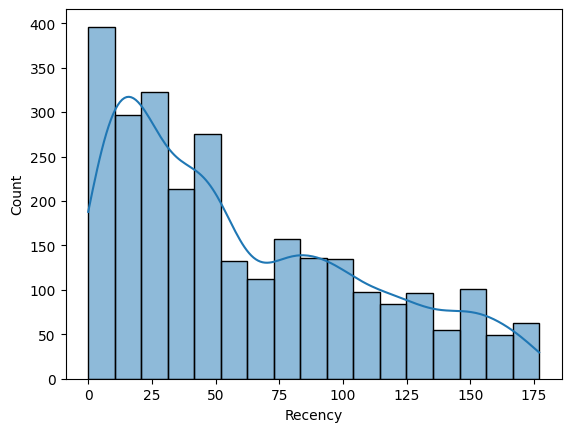

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(rfm['Recency'], kde=True)
plt.show()


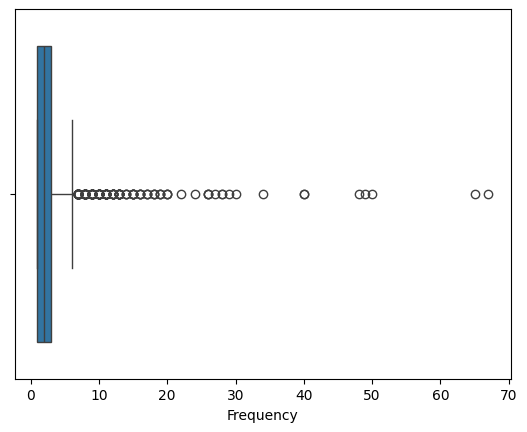

In [23]:
sns.boxplot(x=rfm['Frequency'])
plt.show()

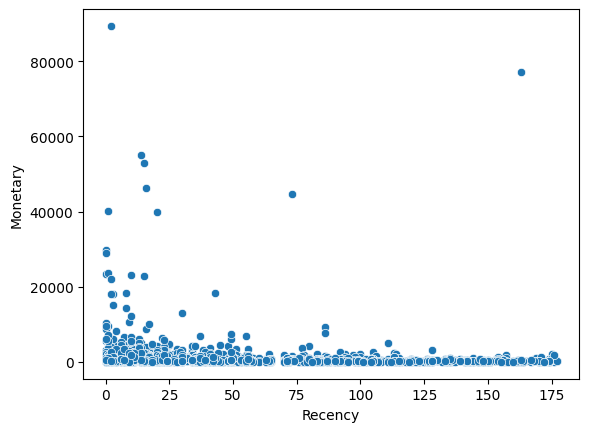

In [24]:
sns.scatterplot(x='Recency', y='Monetary', data=rfm)
plt.show()

<Axes: xlabel='CustomerID'>

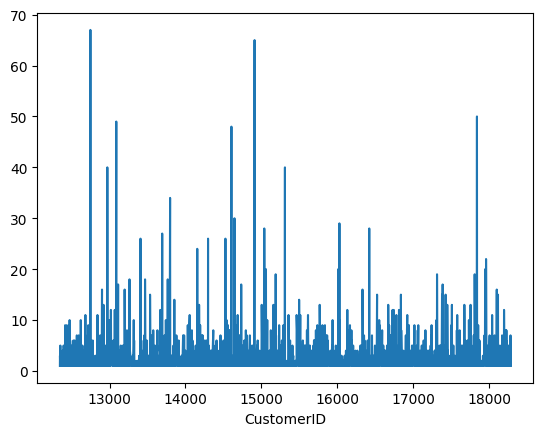

In [27]:
rfm["Frequency"].plot()